Setup

In [1]:
import os
import csv
import numpy as np
from scipy.signal import welch
from scipy.fft import fft, fftfreq
import librosa
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA

# in theory, this should automagically detect whether or not you're in colab and set the directory accordingly
# if in colab, put link to shared 378final folder in My Drive
# if local, make a dataset folder containing the .wav folders in the same directory as the .py file
# we won't track dataset folder on Git because it's 2GB Lol.
try:
    from google.colab import drive
    drive.mount("/content/drive")
    dataset_directory = "/content/drive/My Drive/378final/dataset"
except:
    dataset_directory = "./dataset"

# Hardcoded labels
labels = ["Angry", "Disgusted", "Fearful", "Happy", "Neutral", "Sad", "Suprised"]
# Numpy array makes it easier to make a list from a list of indices
labels = np.asarray(labels)


Data Exploration

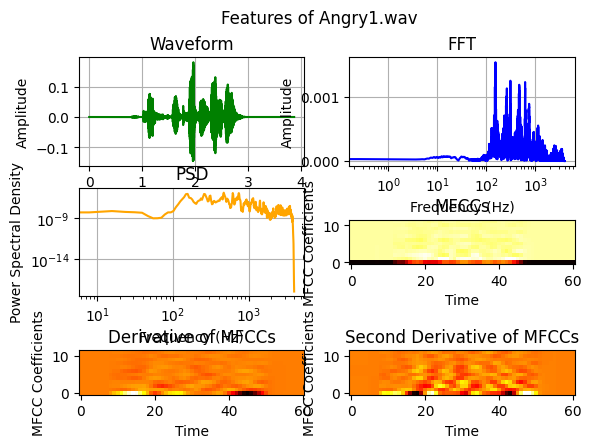

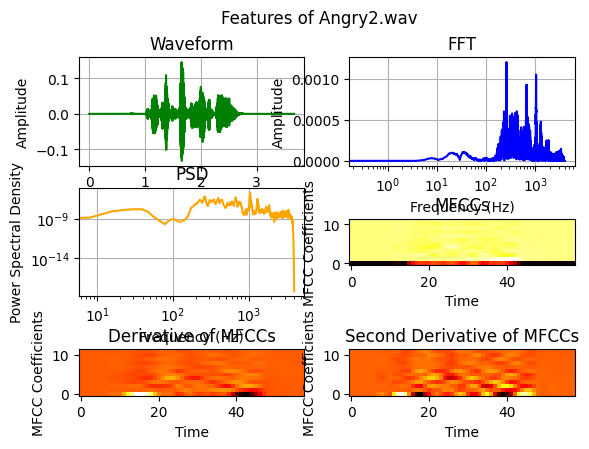

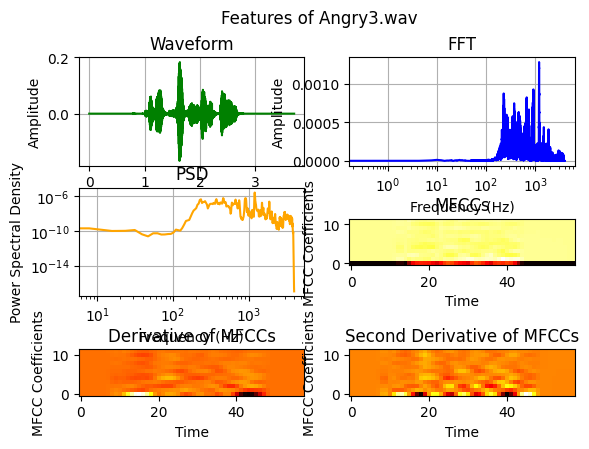

In [ ]:
"""Data Exploration"""

# we would like to get a sense of the signal's properties so see what are some good features to extract
#j = 1
#for emotion in labels:
emotion = "Angry"
for j in range(1, 4):
    file_name = f"{dataset_directory}/{emotion}/{emotion}{j}.wav"
    audio, sampling_rate = librosa.load(file_name, sr=8000)  # load full audio signal

    fig,axs = plt.subplots(3,2)

    # raw audio waveform
    axs[0,0].plot([i/sampling_rate for i in range(audio.shape[0])], audio, color = "green")
    axs[0,0].set_title("Waveform")
    axs[0,0].set_xlabel("Time (s)")
    axs[0,0].set_ylabel("Amplitude")
    axs[0,0].grid()

    # fft
    N = len(audio)
    yf = fft(audio)
    xf = fftfreq(N, 1 / sampling_rate)[:N // 2]
    axs[0,1].plot(xf, 2.0 / N * np.abs(yf[0:N // 2]), color = "blue")
    axs[0,1].set_title("FFT")
    axs[0,1].set_xlabel("Frequency (Hz)")
    axs[0,1].set_ylabel("Amplitude")
    axs[0,1].grid()
    axs[0,1].set_xscale("log")

    # psd
    f, Pxx = welch(audio, sampling_rate, nperseg=1024)
    axs[1,0].set_title("PSD")
    axs[1,0].set_xlabel("Frequency (Hz)")
    axs[1,0].set_ylabel("Power Spectral Density")
    axs[1,0].grid()
    axs[1,0].semilogy(f, Pxx, color = "orange")
    axs[1,0].set_xscale("log")

    # mfcc
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sampling_rate, n_mels=128) #can experiment with n_mels (try 22-128)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    mfccs = librosa.feature.mfcc(S=mel_spec_db, sr=sampling_rate, n_mfcc=12) #experiment with n_mfcc?? (8-20)

    delta_mfccs  = librosa.feature.delta(mfccs)
    delta2_mfccs = librosa.feature.delta(mfccs, order=2)

    axs[1,1].imshow(mfccs, cmap="hot", interpolation="nearest", origin="lower")
    axs[1,1].set_title("MFCCs")
    axs[1,1].set_xlabel("Time")
    axs[1,1].set_ylabel("MFCC Coefficients")

    axs[2,0].imshow(delta_mfccs, cmap="hot", interpolation="nearest", origin="lower")
    axs[2,0].set_title("Derivative of MFCCs")
    axs[2,0].set_xlabel("Time")
    axs[2,0].set_ylabel("MFCC Coefficients")

    axs[2,1].imshow(delta2_mfccs, cmap="hot", interpolation="nearest", origin="lower")
    axs[2,1].set_title("Second Derivative of MFCCs")
    axs[2,1].set_xlabel("Time")
    axs[2,1].set_ylabel("MFCC Coefficients")


    fig.suptitle(f"Features of {emotion}{j}.wav")
    plt.show()


Feature Extraction Function

In [2]:
"""
Feature Extraction (per audio signal)
"""
def extract_features(file_path, standard_audio_size=3):
    try:
        # Load the audio file
        # Apparently the sampling rate differs between files, so we fix it here
        audio, sampling_rate = librosa.load(file_path, sr=8000)

        # Pad/truncate to get standard length (so features are consistent length)
        padded_audio = librosa.util.fix_length(audio, size=standard_audio_size*sampling_rate)

        # Extract features
        mel_spec = librosa.feature.melspectrogram(y=padded_audio, sr=sampling_rate, n_mels=128)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        mfccs = librosa.feature.mfcc(S=mel_spec_db, sr=sampling_rate, n_mfcc=12)
        delta_mfccs  = librosa.feature.delta(mfccs)
        delta2_mfccs = librosa.feature.delta(mfccs, order=2)

        all_features = np.vstack([mfccs, delta_mfccs, delta2_mfccs]).flatten(order='F')
        return all_features
    except Exception as e:
        print(f"Error loading {file_name}: {e}")
        return None


Extracting Train Data

In [ ]:
"""Extracting Train Data"""
print("---Extracting Train Data---")

# Load dataset and extract features
features = []
labels_for_features = []

for label in labels:
    print(f"Extracting: {label}")
    for num, file_name in enumerate(os.listdir(f"{dataset_directory}/{label}")):
        if (num < 100): # comment this out this to use ALL files
            file_path = f"{dataset_directory}/{label}/{file_name}"
            extracted_features = extract_features(file_path)
            if extracted_features is not None:
                features.append(extracted_features)
                labels_for_features.append(label)

# Convert to numpy arrays
features = np.array(features)
labels_for_features = np.array(labels_for_features)
labels_for_features_encoded = [labels.tolist().index(label) for label in labels_for_features]
labels_for_features_encoded = np.array(labels_for_features_encoded)


---Extracting Train Data---
Extracting: Angry
Extracting: Disgusted
Extracting: Fearful
Extracting: Happy
Extracting: Neutral
Extracting: Sad
Extracting: Suprised


Extracting Test Data

In [4]:
"""Extracting Test Data"""
print("---Extracting Test Data---")

test = []
test_features = []
num_test = len(os.listdir(f"{dataset_directory}/Test"))
checkpoints = []
for i in range(1, 5):
    checkpoints.append(round(i*num_test/4))

for i, file_name in enumerate(os.listdir(f"{dataset_directory}/Test")):
    for num in checkpoints:
        if i == num:
            print(f"{int(100*(checkpoints.index(num)+1)/4)}% complete")
    file_path = f"{dataset_directory}/Test/{file_name}"
    the_thing = extract_features(file_path)
    if the_thing is not None:
        test_features.append(the_thing)


---Extracting Test Data---
25% complete
50% complete
75% complete


Training Model and Predicting (SVM w/ PCA)

In [5]:
# delete this cell?
"""Model + Trainer"""
print("---Training Model---")

# Initialize cross-validation (you can use this or simple train test split although this will make testing of your model more robust!)
kf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
accuracies = []

"""
Alternatively, you can also simply use sklearn's train_test_split function!! Cross validation is K different random combinations
of this train and test data split in order to train the model more robustly and ultimately use all your available data for the kaggle competition.
"""

# SVM Model and preprocessing initialization
svm_clf = SVC(kernel="rbf", C=1, gamma="auto")
scaler = StandardScaler()
pca = PCA(n_components=0.95) # keep enough components to preserve 95% of the variance in the data

# Perform cross-validation
for i, (train_index, test_index) in enumerate(kf.split(features, labels_for_features_encoded)):
    print(f"Split #{i+1}")
    X_train, X_test = features[train_index], features[test_index]
    y_train, y_test = labels_for_features_encoded[train_index], labels_for_features_encoded[test_index]
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)
    svm_clf.fit(X_train_pca, y_train)
    y_pred = svm_clf.predict(X_test_pca)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

average_accuracy = np.mean(accuracies)
print(f"Average Accuracy: {average_accuracy * 100:.2f}%")



print("---Making Predictions---")

# Convert list of arrays into a single numpy array
test_scaled = scaler.transform(test_features)
test_pca = pca.transform(test_scaled)

# Predict using the SVM (with decoded predictions)
test_pred = svm_clf.predict(test_pca)
test_pred_labels = labels[test_pred]

# Save to a CSV for submission to Kaggle
with open("svm_PCA.csv", 'w', newline='', encoding="utf-8") as f:
    writer = csv.writer(f)
    writer.writerow(["filename", "emotion"])
    for i, emotion in enumerate(test_pred_labels):
        writer.writerow([f"{str(i+1)}.wav", emotion])


---Training Model---
Split #1
Split #2
Split #3
Split #4
Split #5
Average Accuracy: 32.87%
---Making Predictions---


Training Model and Predicting (SVM w/ RFE)

In [ ]:
"""Reducing Overfitting through Recursive Feature Extraction (RFE)

RFE is a feature selection method that fits a model with the
existing features and removes the weakest feature. This fitting process is repeated until a specified
number of features remains. In this case, the model is initially fit with all the combined features. RFE ranks the features by their importance to the predictive accuracy. The least important
feature is removed recursively. The model is then refitted with the new, reduced set of features. This
process is iterated until the specified number of features is reached.
"""

# Scale features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(features_scaled, labels_for_features_encoded, test_size=0.2, random_state=42)

# Determine if you should use the dual formulation
use_dual = X_train.shape[0] > X_train.shape[1]  # True if more samples than features

# Initialize the LinearSVC model for RFE
linear_svc = LinearSVC(dual=use_dual, max_iter=20000, tol=1e-4)

# Feature selection with RFE using LinearSVC
rfe = RFE(estimator=linear_svc, n_features_to_select=20, step=250, verbose=3)
rfe.fit(X_train, y_train)

# Transform features using RFE
X_train_rfe = rfe.transform(X_train)
X_val_rfe = rfe.transform(X_val)

# Train the final model using the RBF kernel with selected features
model = SVC(kernel="rbf", C=1, decision_function_shape="ovo", gamma="scale")
model.fit(X_train_rfe, y_train)

# Predict on the validation set with the reduced feature set
y_pred = model.predict(X_val_rfe)
validation_accuracy = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy: {validation_accuracy}")

# Predict using the SVM (with decoded predictions)
RFE_test_scaled = scaler.transform(test_features)
RFE_test_transformed = rfe.transform(RFE_test_scaled)
RFE_test_pred = model.predict(RFE_test_transformed)
RFE_test_pred_labels = labels[RFE_test_pred]

# Save to a CSV for submission to Kaggle
with open("svm_RFE.csv", 'w', newline='', encoding="utf-8") as f:
    writer = csv.writer(f)
    writer.writerow(["filename", "emotion"])
    for i, emotion in enumerate(RFE_test_pred_labels):
        writer.writerow([f"{str(i+1)}.wav", emotion])



"""Note on Overfitting:
Note how we tried to mitigate the overfitting problem explicitly at the end through RFE but also implicitly at several prior points in the data science pipeline. We used PCA to capture 95% variance and thus eliminate highly specfic dimensions in feature space that could potentially cause the model to overfit. We also used K-fold cross validation instead of a simple train test split in order to not make training dependent on just one random split of the available data.

Other Ways to Address Overfitting:
* Splitting train validation ratio: The dataset this year is pretty large. The typical train validation split is 80% and 20%. You can always experiment with different ratios to find better performance. However, increasing or decreasing one side too much can lead to overfitting too much to the validation data or underfitting to the validation data.
* Grid search vs random search:
  * Both are ways to tune hyperparameters of your model for better performance. However, both have benefits and downsides.
  * Grid search tries all combinations of hyperparameters in the range of values that you provide. Random search randomly samples hyperparameters in the range of values that you provide.
  * General fast rule of thumb: Use grid search when there are less hyperparameters that also have more correlation with each other. Use random search when there are too many parameters without correlation with each other to see better trends first.
* Early stopping: Use a plot to monitor the validation set performance. When the validation stops improving is when you stop training the model early before it reaches the end of the whole training iterations specified.
* Regularization: Introduce a penalty term in the loss function that prevents over-emphasis and weights on a specific parameter. Different regularization methods were covered in class: L1 (Lasso) and L2 (Ridge).
* Data augmentation: Create more data that is slightly changed from the given train set if you feel you want more training data.
* Too many features: feature selection and dimensionality reduction like PCA.

Other general tips:
*   Consider using raw audio signals vs extracted features of audio signals vs images to train your models.
*   Consider the implications about your data based on the test accuracies of models. For example, if your SVM has a poor accuracy (despite correct implementation), then that most likely implies that your data is probably ont linearly separable. In that case try using kernels or even better for your second model - neural nets!
* CNNs (very common for such tasks, although not SOTA) can be used on 1D (WaveNet), 2D (ResNet), or 3D data (many times people assume it's only for 2D images).
* Transformers are SOTA but take very long to train, especially with Colab's free GPU, so keep that in mind.
* Loading Labels (IMPORTANT): The data for this year has each emotion and their files in a separate folder each without a created train.csv to download. So, please create a train.csv with one column being the filename and second column being the corresponding emotion based on which folder the file is in.
  * NOTE: the emotion "Surprised" is spelled as "Suprised" so use "Suprised" across everything
* Submission file format: Please be aware of the format and follow the format given on Kaggle of two columns with the same column names and format with the emotions having the first letter capitalized.
"""


Fitting estimator with 1692 features.
Fitting estimator with 1442 features.
Fitting estimator with 1192 features.
Fitting estimator with 942 features.
Fitting estimator with 692 features.
Fitting estimator with 442 features.
Fitting estimator with 192 features.
Validation Accuracy: 0.5714285714285714


'Note on Overfitting:\nNote how we tried to mitigate the overfitting problem explicitly at the end through RFE but also implicitly at several prior points in the data science pipeline. We used PCA to capture 95% variance and thus eliminate highly specfic dimensions in feature space that could potentially cause the model to overfit. We also used K-fold cross validation instead of a simple train test split in order to not make training dependent on just one random split of the available data.\n\nOther Ways to Address Overfitting:\n* Splitting train validation ratio: The dataset this year is pretty large. The typical train validation split is 80% and 20%. You can always experiment with different ratios to find better performance. However, increasing or decreasing one side too much can lead to overfitting too much to the validation data or underfitting to the validation data.\n* Grid search vs random search:\n  * Both are ways to tune hyperparameters of your model for better performance. H